In [9]:
#Importing necessary modules
import pandas as pd
from collections import Counter
from cleantext import clean
import nltk
import functions as funs

nltk.download('punkt')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 150)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emilo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#Reading in stopwords
stopwordsDF = pd.read_csv('stopwords.csv')
stopwordsSeries = stopwordsDF.squeeze()
stopwords = set(stopwordsSeries)

In [3]:
#Preprocess pipeline

#Chunksize is 1/8 of the entire dataset
chunk_size = 124375
large_dataset_chunks = pd.read_csv('995,000_rows.csv', low_memory=False, chunksize=chunk_size)

#Initializing list to save the processed data
preprocessed_content_list = []

#Initializing dictionaries to keep track of words and their frequencies
#before and after both removing stopwords and stemming the corpus.
word_frequencies_tokenized = Counter()
word_frequencies_no_stopwords = Counter()
word_frequencies_stemmed = Counter()


#Preprocessing each chunk seperately
for chunk in large_dataset_chunks:

    #Extracting 'content' column chunks and giving dtype string
    chunk_content = chunk['content'].astype(str)

    #Cleaning the 'content' column chunks
    chunk_content = chunk_content.apply(lambda x : clean(x,
    fix_unicode=False,             # fix various unicode errors
    to_ascii=False,                # transliterate to closest ASCII representation
    lower=True,                    # lowercase text
    no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=True,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=True,                # replace all digits with a special token
    no_currency_symbols=True,      # replace all currency symbols with a special token
    no_punct=True,                 # remove punctuations
    replace_with_punct="",         # instead of removing punctuations you may replace them
    replace_with_url="_URL_",
    replace_with_email="_EMAIL_",
    replace_with_phone_number="_PHONE_",
    replace_with_number="_NUMBER_",
    replace_with_digit="0",
    replace_with_currency_symbol="_CUR_",
    lang="en"                    
))
    
    #Final cleaning of the 'content' column chunks
    chunk_content = chunk_content.apply(lambda x: funs.remove_dates_from_content(x))
    chunk_content = chunk_content.apply(lambda x: funs.remove_bar_from_content(x))
    print('Cleaning finished')

    #Tokenizing the 'content' column chunks
    chunk_content = chunk_content.apply(lambda x: nltk.word_tokenize(x))
    print('Tokenization finished')

    #Updating the "word_frequency_tokenized" dictionary
    funs.update_frequency_counter(word_frequencies_tokenized, chunk_content)

    #Removing stopwords from the 'content' column chunks
    chunk_content = chunk_content.apply(lambda x: funs.remove_stopwords(x))
    chunk_content = chunk_content.apply(lambda x: funs.remove_a_from_content(x))
    print('Stopword removal finished')

    #Updating the "word_frequency_no_stopwords" dictionary
    funs.update_frequency_counter(word_frequencies_no_stopwords, chunk_content)

    #Stemming the 'content' column chunks
    chunk_content = chunk_content.apply(lambda x:funs.list_stemmer(x))

    #Updating the "word_frequency_stemmed" dictionary
    funs.update_frequency_counter(word_frequencies_stemmed, chunk_content)
    
    print('Stemming finished')
    preprocessed_content_list.extend(chunk_content.tolist())

print('Preprocessing finished')
    

Cleaning finished
Tokenization finished
Stemming finished
Cleaning finished
Tokenization finished
Stemming finished
Cleaning finished
Tokenization finished
Stemming finished
Cleaning finished
Tokenization finished
Stemming finished
Cleaning finished
Tokenization finished
Stemming finished
Cleaning finished
Tokenization finished
Stemming finished
Cleaning finished
Tokenization finished
Stemming finished
Cleaning finished
Tokenization finished
Stemming finished
Preprocessing finished


In [4]:
#Counting urls, dates and numbers in content

url_count = word_frequencies_tokenized['url']
date_count = word_frequencies_tokenized['date']
number_count = word_frequencies_tokenized['number']

print("Count of URL's in content: ", url_count)
print("Count of dates in content: ", date_count)
print("Count of numbers in content: ", number_count)

Count of URL's in content:  263039
Count of dates in content:  44720
Count of numbers in content:  6209052


In [5]:
#100 most common words in tokenized data
most_common_tokenized = word_frequencies_tokenized.most_common(100)
most_common_words_tokenized = [word for word, count in most_common_tokenized]

#100 most common words in data after removing stopwords
most_common_no_stopwords = word_frequencies_no_stopwords.most_common(100)
most_common_words_no_stopwords = [word for word, count in most_common_no_stopwords]

#100 most common words in stemmed data
most_common_stemmed = word_frequencies_stemmed.most_common(100)
most_common_words_stemmed = [word for word, count in most_common_stemmed]

print('100 most common words in tokenized data: ', most_common_words_tokenized)
print('100 most common words in data after removing stopwords: ', most_common_words_no_stopwords)
print('100 most common words in stemmed data: ', most_common_words_stemmed)

100 most common words in tokenized data:  ['the', 'to', 'of', 'and', 'a', 'in', 'number', 'that', 'is', 'for', 'on', 'it', 'with', 'as', 'was', 'are', 'by', 'this', 'not', 'at', 'be', 'have', 'i', 'from', 'he', 'you', 'an', 'has', 'but', 'his', 'they', 'or', 'we', 'said', 'its', 'will', 'who', 'their', 'more', 'all', 'about', 'new', 'one', 'were', 'which', 'if', 'us', 'can', 'would', 'been', 'up', 'had', 'what', 'people', 'when', 'so', 'our', 'out', 'there', 'no', 'your', 'also', 'like', 'her', 'than', 'do', 'other', 'after', 'some', 'she', 'just', 'time', 'them', 'into', 'my', 'now', 'over', 'only', 'mr', 'even', 'how', 'years', 'first', 'most', 'because', 'two', 'these', 'news', 'could', 'many', 'state', 'president', 'any', 'government', 'may', 'those', 'before', 'states', 'get', 'last']
100 most common words in data after removing stopwords:  ['number', 'people', 'time', 'mr', 'years', 'news', 'state', 'president', 'government', 'states', 'year', 'world', 'trump', 'obama', 'story', 

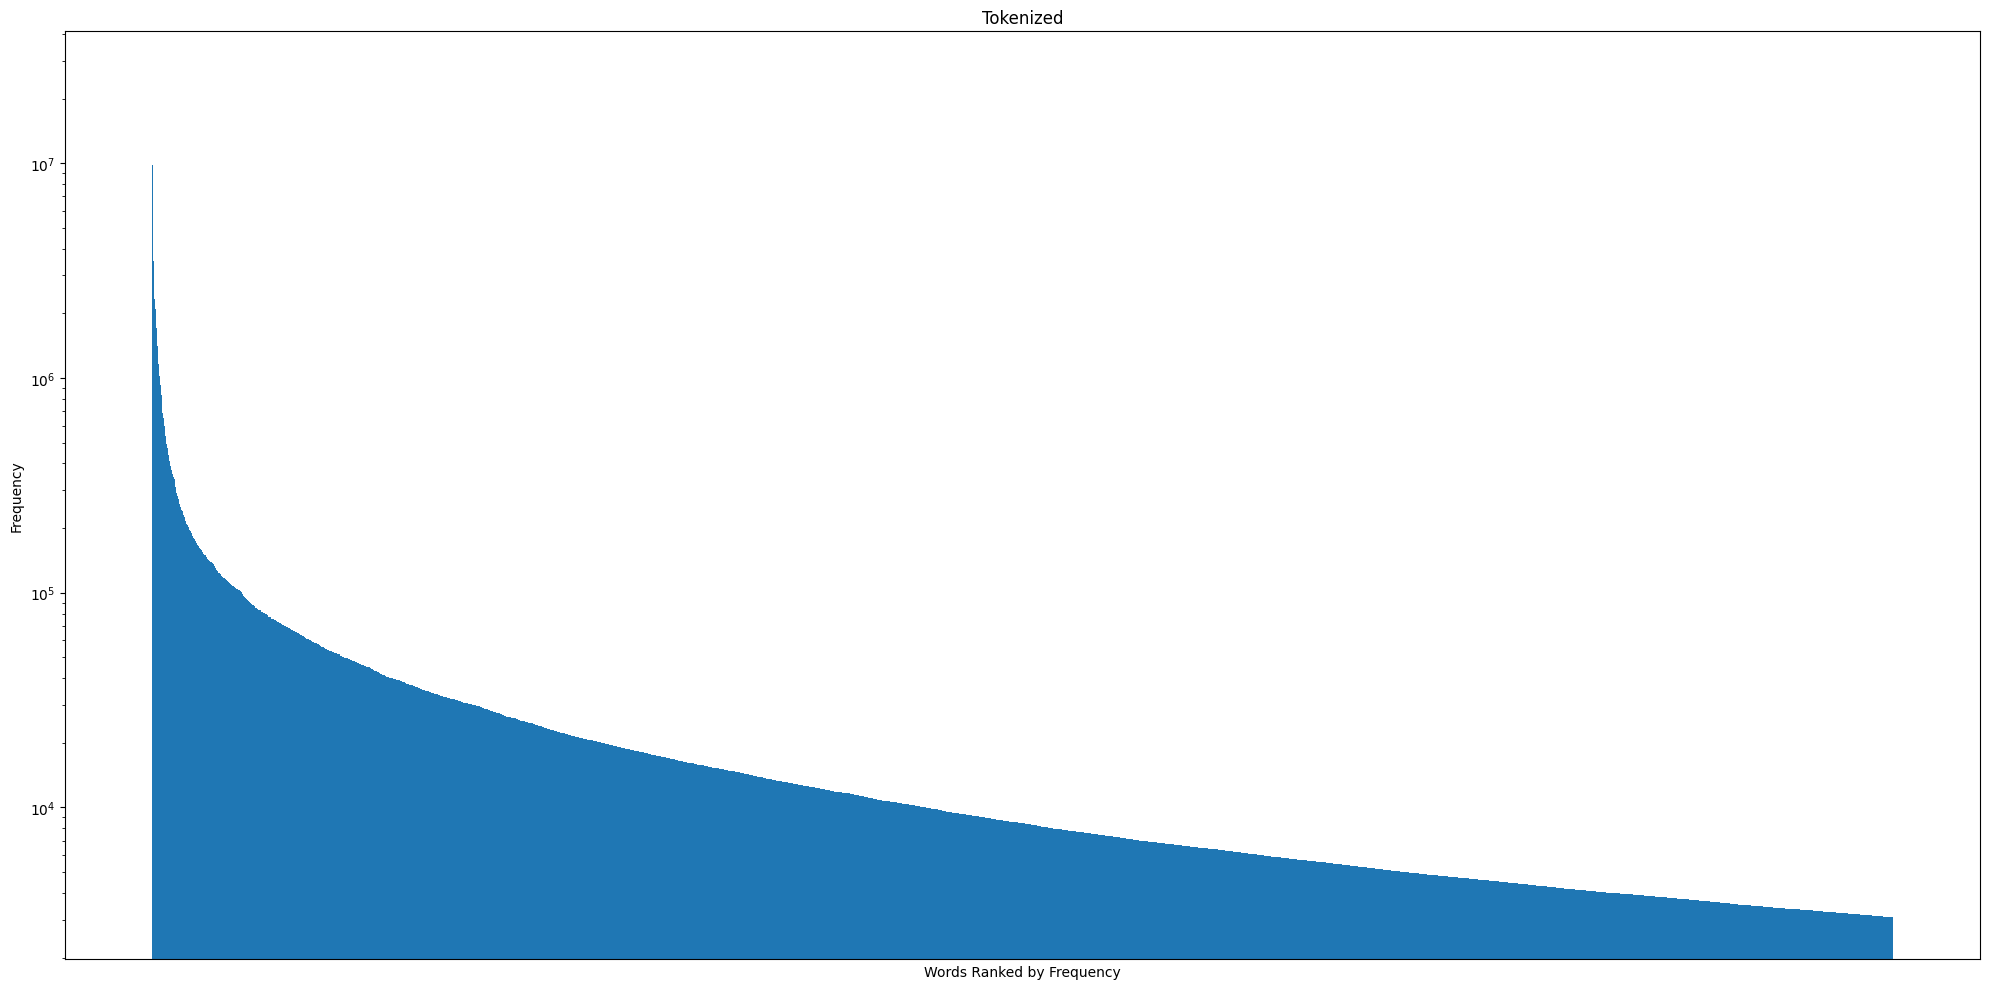

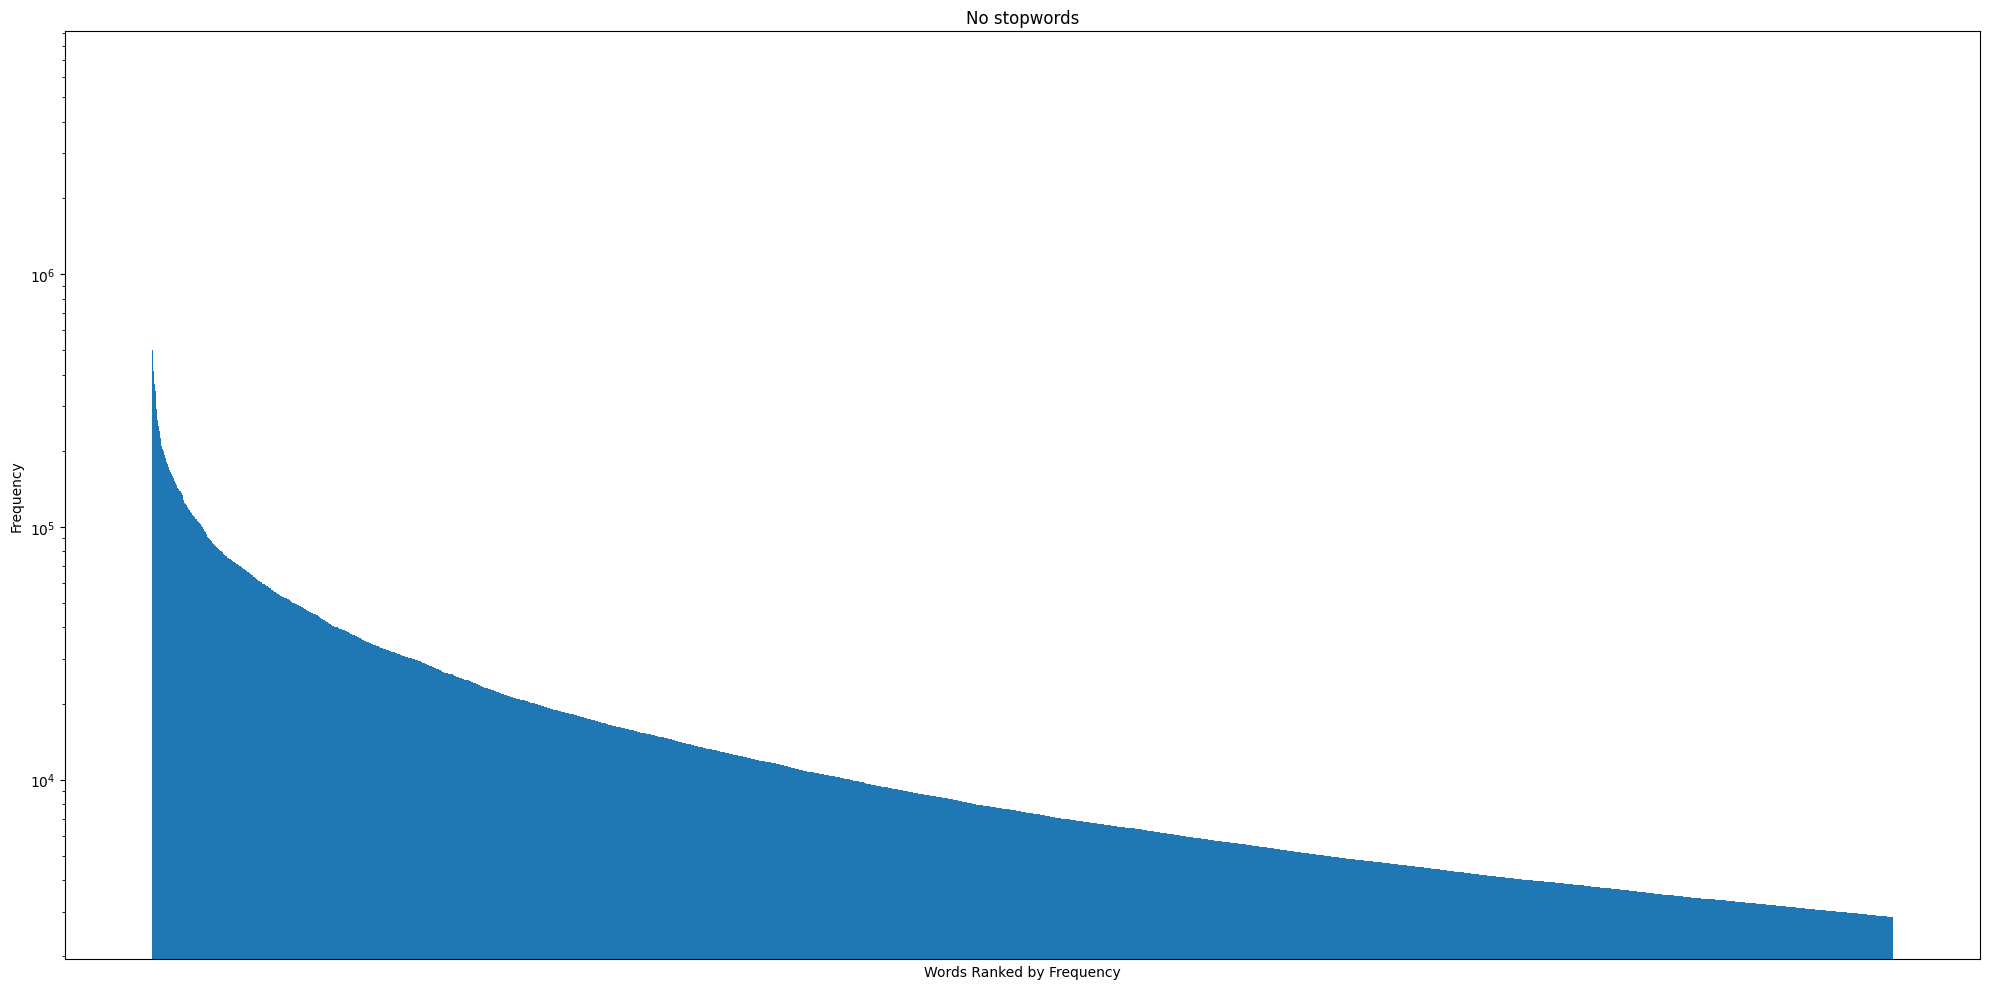

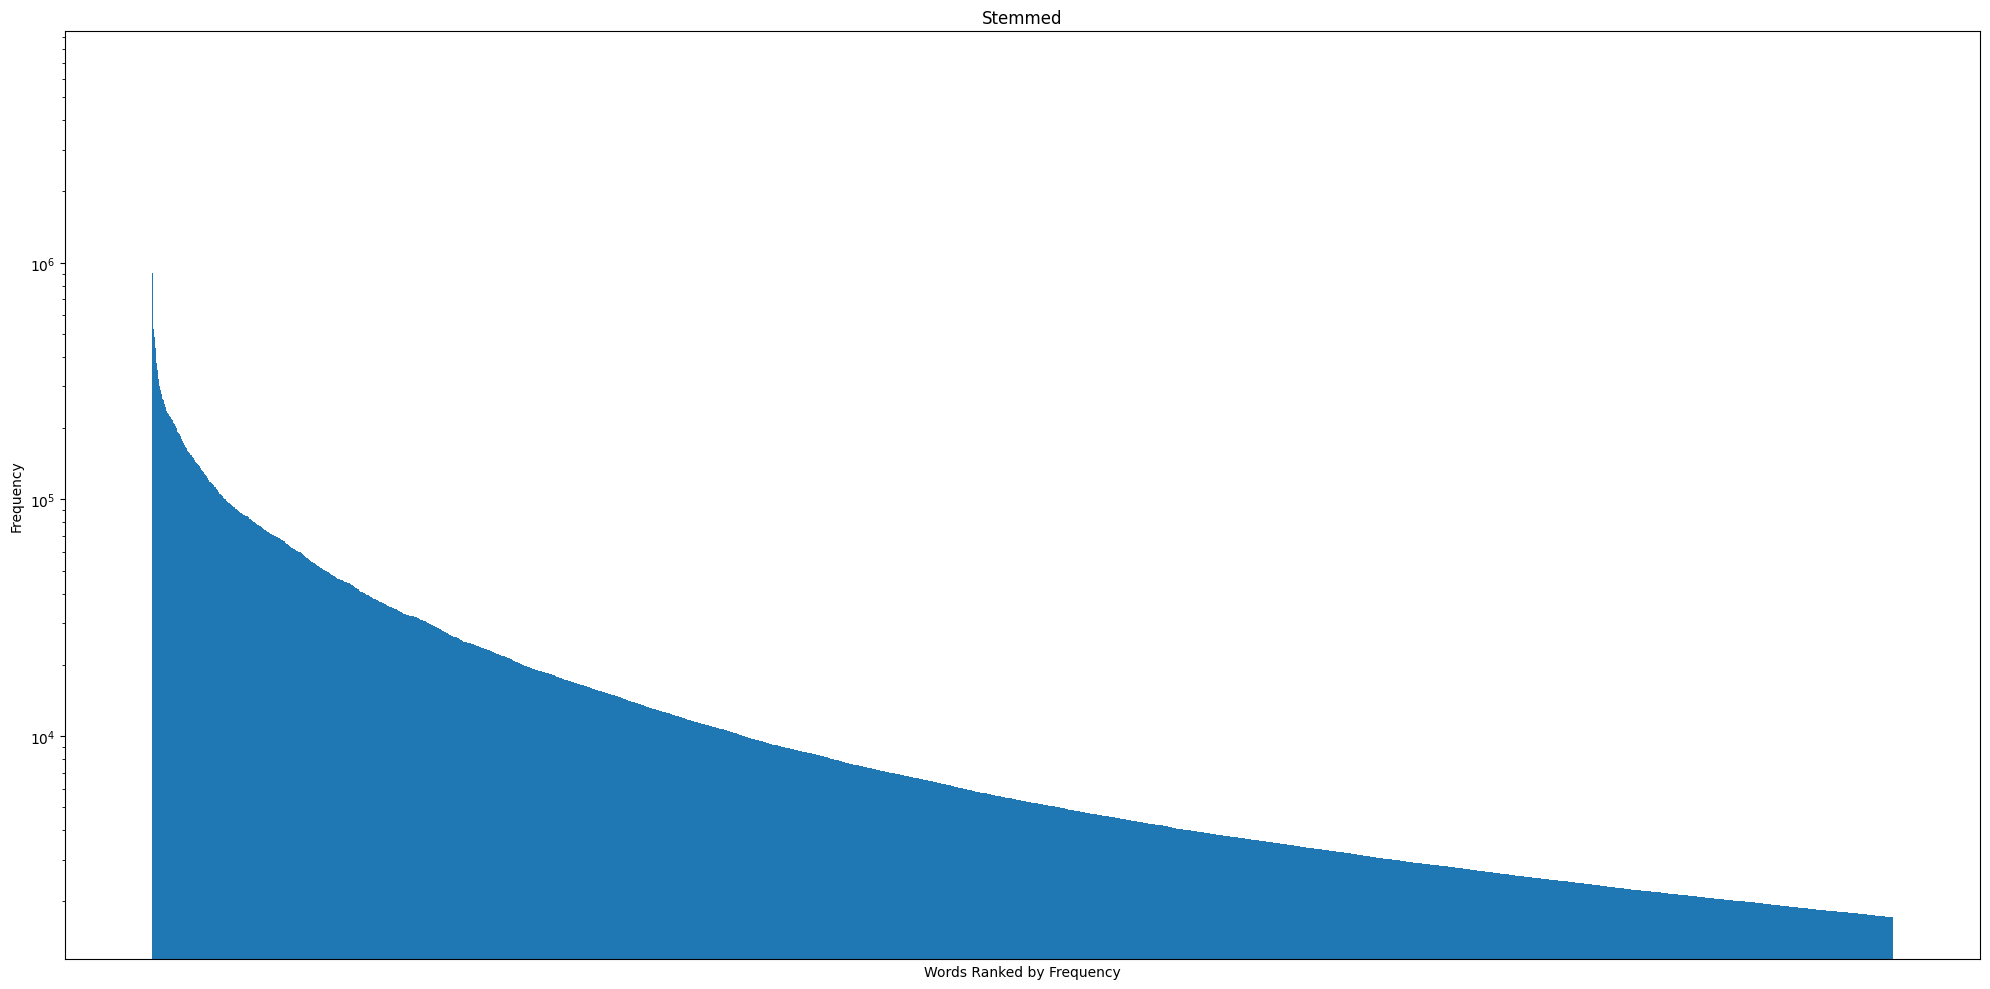

In [6]:
#Plotting the frequency of the 10000 most frequent words - tokenized:
funs.word_frequency_plot(word_frequencies_tokenized, 'Tokenized')
#Plotting the frequency of the 10000 most frequent words - no stopwords:
funs.word_frequency_plot(word_frequencies_no_stopwords, 'No stopwords')
#Plotting the frequency of the 10000 most frequent words - stemmed:
funs.word_frequency_plot(word_frequencies_stemmed, 'Stemmed')

In [7]:
#Converting preprocessed content to series
preprocessed_content_series = pd.Series(preprocessed_content_list)

large_dataset = pd.read_csv('995,000_rows.csv', low_memory=False)

#Changing content column to now contain the preprocessed content
large_dataset['content'] = preprocessed_content_series

#Saving to pickle to preserves list of strings format for each document in the corpus.
#Uncomment to save it to pickle
# large_dataset.to_pickle('995,000_rows_preprocessed.csv')